## function define

In [1]:
def image_loader(f):
    return skimage.io.imread(f)

In [2]:
def Adaptive_Histogram_Equalization(img):
    return equalize_adapthist(img)

In [3]:
def crop_optic_disk(img,mk, margin = 3):
    img_shape = img.shape
    h = np.where(mk>0)[0]
    h = int(mk.shape[0]/2) if h.size == 0 else h
        
    w = np.where(mk>0)[1]
    w = int(mk.shape[1]/2) if w.size == 0 else w
    
    maxh = min(np.unique(h)[-2]+margin, mk.shape[0])
    minh = max(np.unique(h)[3]-margin, 0)
    maxw = min(np.unique(w)[-2]+margin, mk.shape[1])
    minw = max(np.unique(w)[3]-margin, 0)
    
    img = img[minh:maxh,minw:maxw,:]
    img = resize(img, img_shape)
    return img

In [4]:
def resize_image(img,shape):
    img = resize(img,shape)
    return img

In [5]:
def cleaner(mak, ignore =1):
    idx = []
    tmp = np.pad(mak,3,mode = 'constant', constant_values=0)[:,:,3:6]
    for i in range(tmp.shape[0]-3):
        for j in range(tmp.shape[1]-3):
            if np.sum(tmp[i:i+3,j:j+3,:]> 100) <= ignore*3 :
                idx.append((i,j,3))
    for (i,j,_) in idx:
        tmp[i:i+3,j:j+3,:] = np.zeros((3,3,3))
    return tmp[3:-3,3:-3,:]

In [6]:
def normalize_img(img):
    shape = img.shape
    img = np.float64(img.reshape(-1))
    img -= img.mean()
    img /= img.std()
    img = img.reshape(shape)
#     img = img/ 255
    return img

In [7]:
def random_gamma(img):
    gamma = random.uniform(1.5,1.0)
    gain = random.uniform(1.8,0.5)
    return adjust_gamma(img,gamma, gain)

## import libs

In [1]:
import numpy as np
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
sys.path = ["C:\\Users\\infinigru\\Anaconda3\\envs\\prac\\lib\\site-packages"] + sys.path
# from train_generator import batch_iterator, random_rotate, random_image_shift
# from utils.util import train_progressbar, slack_message
# from config import TRAIN_FILE, TEST_FILE
import os
import random
import cv2
import polarTransform

from config import *
from iterator import DataIterator

Using TensorFlow backend.


In [2]:
from utils.image_util import image_loader, resize_image, image_rotate, random_gamma, Adaptive_Histogram_Equalization, random_flip_image, normalize_img, crop_optic_disk, polartransform_image

In [3]:
import skimage
from skimage.exposure import equalize_adapthist, adjust_gamma
from skimage.transform import rescale, resize, downscale_local_mean, rotate

## Generator

In [13]:
augm = {"gamma":False, "rotate":False, "polar":False, "hiseq":False, "normal":True, "flip":False, "copy":True}
## load batch generator
print(f"\ntrain data from : {TRAIN_DATASET}")
train_iterator = DataIterator(TRAIN_DATASET, 1, OPTIC_DISC_SHAPE
                              , is_train=True
                              , rotate = augm['rotate'], polar = augm['polar'], hiseq = augm['hiseq']
                              , gamma = augm['gamma'], flip = augm['flip'], normal = augm['normal'])

print(f"\ntest data from : {TEST_DATASET}")
test_iterator = DataIterator(TEST_DATASET, 1, OPTIC_DISC_SHAPE
                              , is_train=False, polar= augm['polar'], hiseq = augm['hiseq'], normal = augm['normal'])


train data from : C:\Projects\my_Glaucoma_project_v2\dataset\train.h5

test data from : C:\Projects\my_Glaucoma_project_v2\dataset\test.h5


In [14]:
i=0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


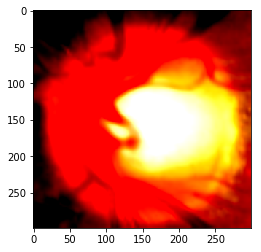

[0.]


In [29]:
item, y_true = train_iterator[i] #V0217.jpg V0127.jpg
plt.imshow(item[0])
plt.show()
print(y_true[0])
i +=1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


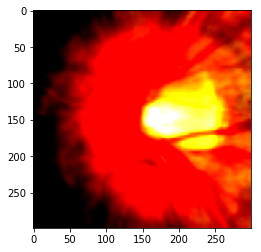

[0.]


In [30]:
item, y_true = test_iterator[i] #V0217.jpg V0127.jpg
plt.imshow(item[0])
plt.show()
print(y_true[0])
i += 1

### unit test

In [4]:
test = 'V0317'
im = os.path.join(TRAIN_IMAGE,'Non-Glaucoma',test+'.jpg')
ma = os.path.join(MASK_LOC,'mask_'+test+'.jpg')
image =image_loader(im)
mask =image_loader(ma)

In [5]:
os.path.join(MASK_LOC,'mask_'+'n0137'+'.jpg')

'D:\\Projects\\my_Glaucoma_project_v2\\dataset\\Glaucoma\\mask_od\\mask_n0137.jpg'

In [6]:
image = resize_image(image,(512, 512, 3))

## segment generator

In [1]:
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
sys.path = ["C:\\Users\\infinigru\\Anaconda3\\envs\\prac\\lib\\site-packages"] + sys.path
import keras 
from seg_iterator import DataIterator
import cv2
print(cv2.__version__)
from config import *

Using TensorFlow backend.


3.4.2


In [2]:
augm = {"gamma":True, "rotate":False, "flip":True, "hiseq":False, "normal":True, "invert":False, "crop":True}

## load batch generator
print(f"\ntrain data from : {MASKING_TRAIN_IMAGE}")
train_iterator = DataIterator(TRAIN_IMAGE, MASKING_TRAIN_IMAGE, 1, IMAGE_SHAPE, is_train=True, sample = 10
                            , gamma=augm["gamma"], rotate=augm["rotate"], flip=augm["flip"]
                              , hiseq=augm["hiseq"], normal=augm["normal"], invert=augm["invert"], crop = augm["crop"])

print(f"\ntest data from : {MASKING_VAL_IMAGE}")
test_iterator = DataIterator(TRAIN_IMAGE, MASKING_VAL_IMAGE, 1, IMAGE_SHAPE, is_train=False,sample = 10
                            , hiseq=augm["hiseq"], normal=augm["normal"])


train data from : D:\Projects\my_Glaucoma_project_v2\dataset\Glaucoma\mask_od\GT\train
 [>>________________________________________________] 10 Done
test data from : D:\Projects\my_Glaucoma_project_v2\dataset\Glaucoma\mask_od\GT\val
 [>>>>>>>>>>>>>>>>>>>>>>>>>_________________________] 10 Done

In [16]:
i =0 

In [ ]:
train_iterator.on_epoch_end()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


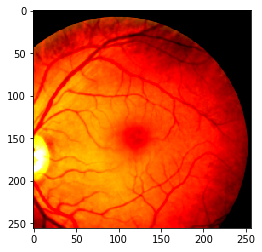

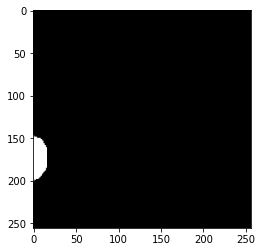

In [19]:
train_images, train_labels = train_iterator[i]
plt.imshow(train_images[0])
plt.show()
plt.imshow(train_labels[0][:,:,1].reshape(IMAGE_SHAPE[:2]), cmap='gray', vmin=0, vmax=1)
plt.show()
i += 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


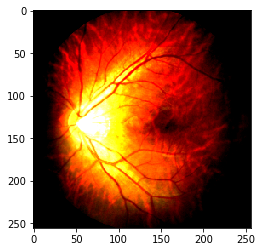

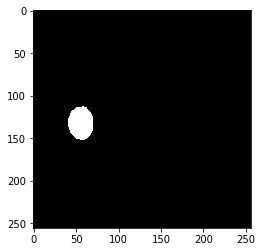

In [5]:
train_images, train_labels = test_iterator[i]
plt.imshow(train_images[0])
plt.show()
plt.imshow(train_labels[0][:,:,1].reshape(IMAGE_SHAPE[:2]), cmap='gray', vmin=0, vmax=1)
plt.show()
# i += 1